# **Downloading Data**

https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_eval_partition.csv

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ! mkdir ~/.kaggle
# # ! cp /content/drive/MyDrive/Data/Docs/Keys/kaggle.json ~/.kaggle/   # 0
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/                  # 1, 2
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d jessicali9530/celeba-dataset
# ! unzip celeba-dataset.zip -d data/

# # ! cp -r data/ /content/drive/MyDrive/Temp/Datasets/celeba/
# # ! cp data/list_eval_partition.csv /content/drive/MyDrive/Temp/Datasets/celeba/data/img_align_celeba/

Streaming output truncated to the last 5000 lines.
  inflating: data/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: data/img_align_celeba/img_

# **Initializing**

In [1]:
PATH = "/content/data"
# SAVE_PATH = "/content/drive/MyDrive/Temp/Dumps/celeb_faces" # 0
SAVE_PATH = "/content/drive/MyDrive/CelebFacesDumps"        # 1

In [2]:
import os
os.listdir(PATH)

['list_bbox_celeba.csv',
 'list_attr_celeba.csv',
 'img_align_celeba',
 'list_landmarks_align_celeba.csv',
 'list_eval_partition.csv']

In [3]:
IMGS_PATH = os.path.join(PATH, "img_align_celeba/img_align_celeba")
ATTR_PATH = os.path.join(PATH, "list_attr_celeba.csv")
EVAL_PATH = os.path.join(PATH, "list_eval_partition.csv")

In [4]:
# Importing Modules
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import sys
import random

from tensorflow.keras import models, layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# **Preprocessing**

In [5]:
N = 20_000  # samples allowed at max by RAM
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

## Finding Number of Samples To use

In [6]:
# Reading Data
df = pd.read_csv(ATTR_PATH)
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [7]:
# COL = "Male"
COLS = ['Male', 'Smiling', 'Young']

In [8]:
# Setting image_id as index
df.set_index('image_id', inplace=True)

# Replacing -1 with 0
df.replace(to_replace=-1, value=0, inplace=True)

# Extracting only the selected columns
df = df[COLS]

# Shufflig The DataFrame
df = df.sample(frac = 1)

df.head()

,Male,Smiling,Young
image_id,,,
124504.jpg,1,0,1
009392.jpg,0,1,1
007188.jpg,0,1,1
070919.jpg,1,0,1
131015.jpg,1,0,1


In [9]:
n_from_each_class = min(df.value_counts())
print("Min Available in Each Class:", n_from_each_class)
N_each = N // (2**len(COLS))
if n_from_each_class > N_each:
    n_from_each_class = N_each
n_from_each_class
print("Max Allowed Samples from each class:", N_each)

selected_ids = []
for mode in df.value_counts().index:
    temp_df = df
    for i, m in enumerate(mode):
        temp_df = temp_df[
            temp_df[COLS[i]] == m
        ]
    selected_ids.extend(temp_df.index.values[:n_from_each_class])

N = len(selected_ids)

print("Total Samples Taken:", N)

Min Available in Each Class: 4687
Max Allowed Samples from each class: 2500
Total Samples Taken: 20000


## Preparing Y

In [10]:
# Taking only the selected imgages
df = df.loc[selected_ids]

In [11]:
# Putting the final numpy array in Y
Y = df.values
Y.shape

(20000, 3)

In [12]:
df.value_counts()

Male  Smiling  Young
0     0        0        2500
               1        2500
      1        0        2500
               1        2500
1     0        0        2500
               1        2500
      1        0        2500
               1        2500
dtype: int64

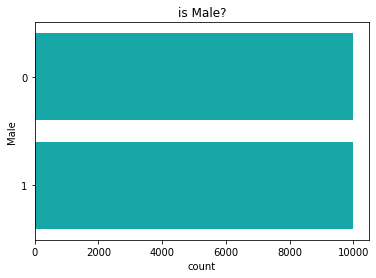

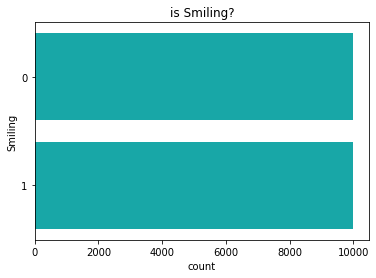

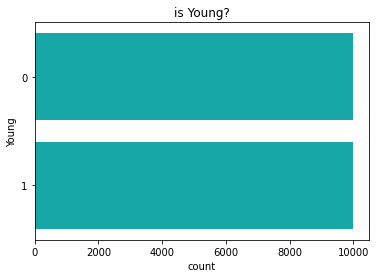

In [13]:
for col in COLS:
    plt.title(f"is {col}?")
    sns.countplot(y=col, data=df, color="c")
    plt.show()

## Splitting

In [14]:
from sklearn.model_selection import train_test_split

train_selected_ids, test_selected_ids, Y_train, Y_test = train_test_split(
    selected_ids,
    Y,
    test_size = 0.25,
    stratify = Y,
)

del selected_ids
del Y

## Preparing X

In [15]:
X_train = []

with tf.device("/GPU:0"):
    for img_name in tqdm(train_selected_ids):
        img_path = os.path.join(IMGS_PATH, img_name)
        img = np.array(tf.keras.preprocessing.image.load_img(
            img_path,
            target_size = IMG_SIZE,
        ))
        X_train.append(img)

X_train = np.array(X_train)
X_train = tf.keras.applications.inception_v3.preprocess_input(X_train)

# X_train = tf.Variable(X_train)

100%|██████████| 15000/15000 [00:38<00:00, 387.48it/s]


In [16]:
X_test = []

with tf.device("/GPU:0"):
    for img_name in tqdm(test_selected_ids):
        img_path = os.path.join(IMGS_PATH, img_name)
        img = np.array(tf.keras.preprocessing.image.load_img(
            img_path,
            target_size = IMG_SIZE,
        ))
        X_test.append(img)

X_test = np.array(X_test)
X_test = tf.keras.applications.inception_v3.preprocess_input(X_test)

# X_test = tf.Variable(X_test)

100%|██████████| 5000/5000 [00:10<00:00, 484.53it/s]


## Visualizing Some

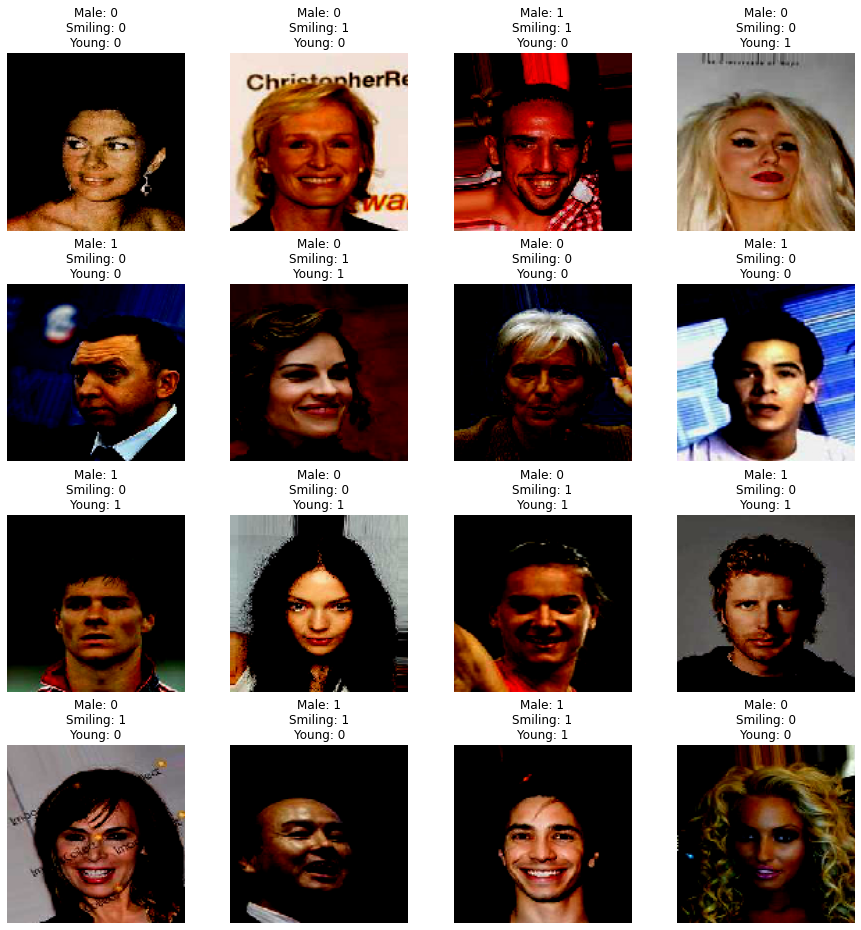

In [17]:
r = 4       # better to not change this
n = r**2

fig, axes = plt.subplots(
	r,    # no of rows
	r,    # no of cols
	figsize = (16, 16)
)
fig.subplots_adjust(hspace=0.1 * len(COLS), wspace=0)

for n_ in range(n):
    ax = axes[n_ // r][n_ % r]
    i = random.randint(0, len(Y_train))

    x = X_train[i]
    y = Y_train[i]

    # title = f"{COL}: {y}"
    title = "\n".join([f"{c}: {y_}" for (c, y_) in zip(COLS, y)])

    ax.set_title(title)
    ax.axis('off')
    ax.imshow(x)

plt.show()

## Data Generator

In [18]:
image_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
	rotation_range=30,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.2,
	zoom_range=0.2,
	horizontal_flip=True,
)
image_data_gen.fit(X_train)
train_datagen = image_data_gen.flow(
	X_train,
	Y_train,
	batch_size = BATCH_SIZE,
	shuffle=True,
)

In [19]:
del X_train
del Y_train

# **Model**

In [20]:
INPUT_SHAPE = IMG_SIZE + (3,)
OUTPUT_SHAPE = Y_test.shape[-1]
N_rigid_layers = 15

INPUT_SHAPE, OUTPUT_SHAPE

((128, 128, 3), 3)

## Functional Model

### Structuring The Functional Model

In [ ]:
# input = layers.Input(shape=INPUT_SHAPE)

In [ ]:
# inception_model = tf.keras.applications.InceptionV3(
#     include_top=False,
#     # input_shape=INPUT_SHAPE,
#     pooling="avg",
# )

# print("No of Inception Layers:", len(inception_model.layers))
# print("No of Locked Layers:", N_rigid_layers)

# # Lock initial layers to do not be trained
# for layer in inception_model.layers[:N_rigid_layers]:
#     layer.trainable = False

# # Creating Layer
# inception_layer = inception_model(input)

No of Inception Layers: 312
No of Locked Layers: 52


In [ ]:
# outputs = []
# for i, col in enumerate(COLS):
#     hidden = models.Sequential([

#         layers.Dense(1024, activation="relu"),
#         layers.Dense(512, activation="relu"),
#         layers.Dense(1, activation="sigmoid"),

#     ], name=col)(inception_layer)
#     outputs.append(hidden)

In [ ]:
# model = models.Model(input, outputs)

In [ ]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_1[0][0]']                
                                                                                                  
 Male (Sequential)              (None, 1)            2623489     ['inception_v3[0][0]']           
                                                                                                  
 Smiling (Sequential)           (None, 1)            2623489     ['inception_v3[0][0]']       

### Compiling and Training

In [ ]:
# LR = 0.002
# MOMENTUM = 0.9

# EPOCHS = 5
# STEPS_PER_EPOCH = ( N - len(Y_test) ) // BATCH_SIZE
# # STEPS_PER_EPOCH = 100

# model.compile(
#     # optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
#     optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
#     loss = ["binary_crossentropy"]*3,
#     metrics = ["accuracy"]
# )
# with tf.device("/GPU:0"):
#     history = model.fit(
#         train_datagen,
#         epochs=EPOCHS,
#         steps_per_epoch = STEPS_PER_EPOCH,
#         validation_data = (X_test, [*np.expand_dims(Y_test.T, 2)]), # For Functional Model outputs
#         # validation_data=(X_test, Y_test),
#         verbose = 1,
#     ).history

Epoch 1/5
1125/1125 [==============================] - 137s 107ms/step - loss: 1.9242 - Male_loss: 0.6412 - Smiling_loss: 0.6411 - Young_loss: 0.6419 - Male_accuracy: 0.6241 - Smiling_accuracy: 0.6255 - Young_accuracy: 0.6237 - val_loss: 1.8772 - val_Male_loss: 0.5580 - val_Smiling_loss: 0.6262 - val_Young_loss: 0.6930 - val_Male_accuracy: 0.7330 - val_Smiling_accuracy: 0.6757 - val_Young_accuracy: 0.5810
Epoch 2/5
1125/1125 [==============================] - 111s 99ms/step - loss: 1.8276 - Male_loss: 0.6093 - Smiling_loss: 0.6090 - Young_loss: 0.6093 - Male_accuracy: 0.6630 - Smiling_accuracy: 0.6620 - Young_accuracy: 0.6624 - val_loss: 1.7849 - val_Male_loss: 0.5650 - val_Smiling_loss: 0.5623 - val_Young_loss: 0.6576 - val_Male_accuracy: 0.6998 - val_Smiling_accuracy: 0.7208 - val_Young_accuracy: 0.6003
Epoch 3/5
1125/1125 [==============================] - 107s 95ms/step - loss: 1.7973 - Male_loss: 0.5991 - Smiling_loss: 0.5992 - Young_loss: 0.5990 - Male_accuracy: 0.6699 - Smiling_

## Sequential Model

In [21]:
# ===> Input Layer
input = layers.Input(shape=INPUT_SHAPE)

# ===> Inception Model
inception_model = tf.keras.applications.InceptionV3(
    include_top=False
)
print("No of Inception Layers:", len(inception_model.layers))
print("No of Locked Layers:", N_rigid_layers)
# Lock initial layers to do not be trained
for layer in inception_model.layers[:N_rigid_layers]:
    layer.trainable = False
inception_layers = inception_model(input)

# ===> Hidden Layers
hidden_model = models.Sequential([

    # layers.Conv2D(16, kernel_size=3, padding='SAME', activation='relu'),
    # layers.AveragePooling2D(3),
    # layers.Conv2D(32, kernel_size=3, padding='SAME', activation='relu'),
    # layers.AveragePooling2D(3),
    # layers.Conv2D(64, kernel_size=3, padding='SAME', activation='relu'),
    # layers.AveragePooling2D(3),

    layers.Flatten(),

    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(OUTPUT_SHAPE, activation='sigmoid')
])
hidden_layers = hidden_model(inception_layers)

# ===> Output Layer
# outputs = []
# for i, col in enumerate(COLS):
#     out = layers.Lambda(lambda x: x[...,i:i+1], name=col)(hidden_layers)
#     outputs.append(out)

# ===> Final Model
model = models.Model(input, hidden_layers)

# hidden_model.summary()
model.summary()

No of Inception Layers: 311
No of Locked Layers: 15
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 sequential (Sequential)     (None, 3)                 8915971   
                                                                 
Total params: 30,718,755
Trainable params: 30,512,243
Non-trainable params: 206,512
_________________________________________________________________


In [22]:
EPOCHS = 15
STEPS_PER_EPOCH = ( N - len(Y_test) ) / BATCH_SIZE
STEPS_PER_EPOCH = 100
LR = 0.0008
MOMENTUM = 0.98

model.compile(
    # optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
    loss = "binary_crossentropy",
    metrics = ["acc"]
)

with tf.device("/GPU:0"):
    history = model.fit(
        train_datagen,
        epochs=EPOCHS,
        steps_per_epoch = STEPS_PER_EPOCH,
        validation_data=(X_test, Y_test),
        verbose = 1,
    ).history

Epoch 1/15
100/100 [==============================] - 36s 184ms/step - loss: 0.7233 - acc: 0.3631 - val_loss: 0.6713 - val_acc: 0.3304
Epoch 2/15
100/100 [==============================] - 14s 140ms/step - loss: 0.6622 - acc: 0.4711 - val_loss: 0.6241 - val_acc: 0.3762
Epoch 3/15
100/100 [==============================] - 15s 153ms/step - loss: 0.6043 - acc: 0.5631 - val_loss: 0.5392 - val_acc: 0.5946
Epoch 4/15
100/100 [==============================] - 13s 133ms/step - loss: 0.5779 - acc: 0.6187 - val_loss: 0.5186 - val_acc: 0.6466
Epoch 5/15
100/100 [==============================] - 15s 147ms/step - loss: 0.5311 - acc: 0.6506 - val_loss: 0.4425 - val_acc: 0.7264
Epoch 6/15
100/100 [==============================] - 15s 148ms/step - loss: 0.5017 - acc: 0.6356 - val_loss: 0.4428 - val_acc: 0.7544
Epoch 7/15
100/100 [==============================] - 15s 151ms/step - loss: 0.4649 - acc: 0.7269 - val_loss: 0.3933 - val_acc: 0.7842
Epoch 8/15
100/100 [==============================] - 1

In [25]:
model.evaluate(X_test, Y_test)

188/188 [==============================] - 6s 32ms/step - loss: 0.2810 - acc: 0.7955


[0.28095102310180664, 0.7954999804496765]

In [23]:
pred_test = model.predict(X_test)
# pred_test = np.squeeze(np.array(pred_test), 2).T  # For Funcitonal
pred_test = pred_test.round().astype(int)

acc = (Y_test == pred_test)

total = len(acc.ravel())
correct = acc.sum()

print()
print(f"Correct Predictions:\t\t{correct}/{total} ({round(correct/total, 3)}))", )
for i, col in enumerate(COLS):
    total_i = total//len(COLS)
    correct_i = acc.sum(0)[i]
    print(f"{col} Correct Predictions:\t{correct_i}/{total_i} ({round(correct_i/total_i, 3)})")

157/157 [==============================] - 6s 29ms/step

Correct Predictions:		12806/15000 (0.854))
Male Correct Predictions:	4691/5000 (0.938)
Smiling Correct Predictions:	4334/5000 (0.867)
Young Correct Predictions:	3781/5000 (0.756)


In [ ]:
"""
Correct Predictions:		16103/18000 (0.895))
Male Correct Predictions:	5832/6000 (0.972)
Smiling Correct Predictions:	5378/6000 (0.896)
Young Correct Predictions:	4893/6000 (0.816)
"""

# Saving the model
# model.save(f"{SAVE_PATH}/{','.join(COLS)}_model.h5")

## Plotting Loss and Metrics

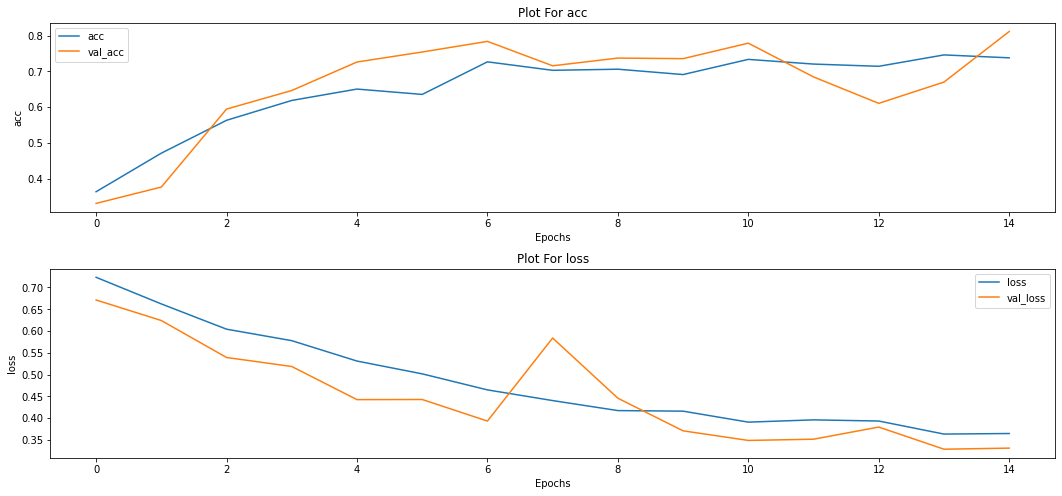

In [33]:
keys = ['acc', 'loss']

fig, axes = plt.subplots(
	len(keys),  # no of rows
	1,          # no of cols
	figsize = (18, 4*len(keys)),
)
fig.subplots_adjust(hspace=0.3)

for i, key in enumerate(keys):
    ax = axes[i]
    ax.set_title("Plot For " + key)
    for hist_key in [i for i in history.keys() if key in i]:
        ax.plot(history[hist_key], label=hist_key)
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(key)

# # Saving the figure
plt.savefig(f"{SAVE_PATH}/{','.join(COLS)}_graph")

plt.show()

## Testing on Test Data

In [25]:
r = 4       # better to not change this
n = r**2

rand_inds = [random.randint(0, len(Y_test)) for i in range(n)]
xs = X_test[rand_inds]
ys = Y_test[rand_inds]
preds = model.predict(xs).round().astype(int)
# For Functional Model
# preds = np.squeeze(preds).T.round().astype(int)

acc = ys == preds
print()
print(f"Correct Predictions:\t\t{acc.sum()}/{len(preds.ravel())}", )
for i, col in enumerate(COLS):
    print(f"{col} Correct Predictions:\t{acc.sum(0)[i]}/{len(preds.ravel())//3}")

1/1 [==============================] - 0s 33ms/step

Correct Predictions:		40/48
Male Correct Predictions:	15/16
Smiling Correct Predictions:	15/16
Young Correct Predictions:	10/16


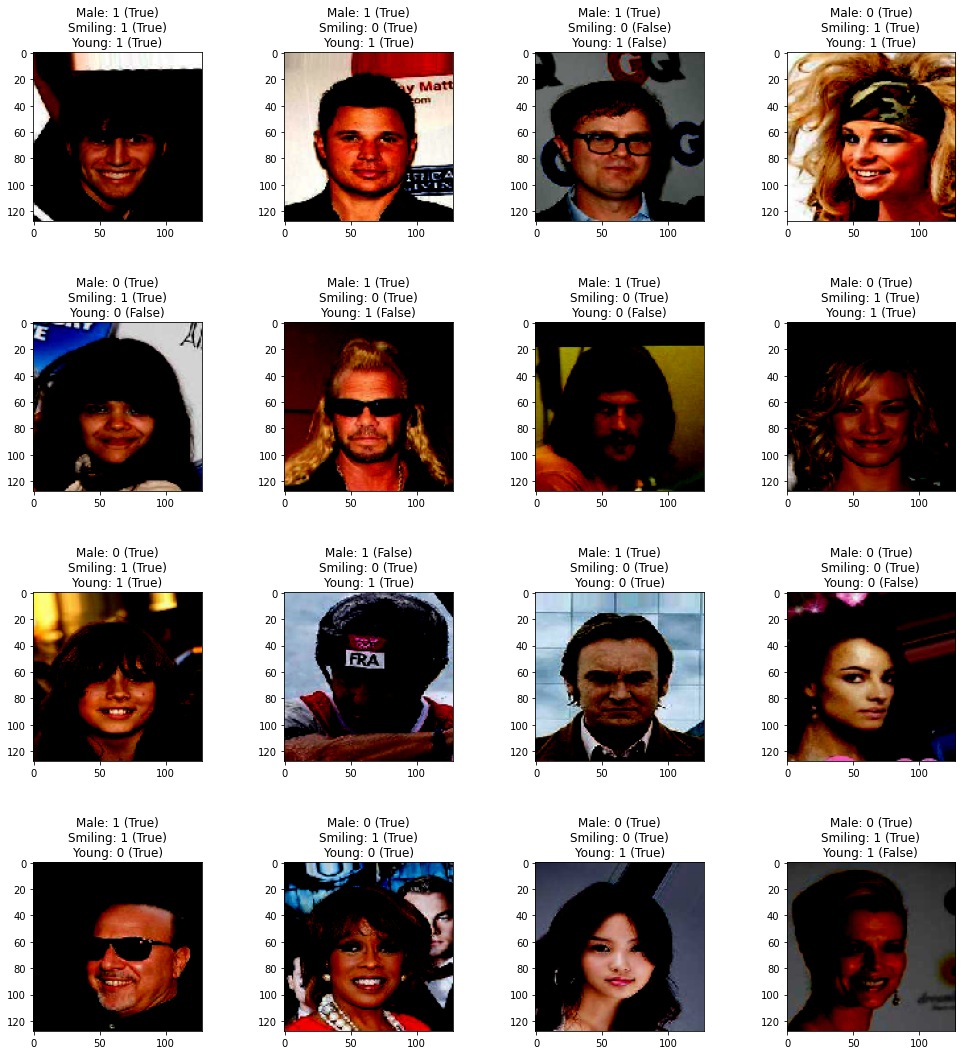

In [26]:
fig, axes = plt.subplots(
	r,    # no of rows
	r,    # no of cols
	figsize = (18, 18)
)
fig.subplots_adjust(hspace=0.2 * len(COLS), wspace=0)

for i in range(n):
    ax = axes[i // r][i % r]

    x = xs[i]
    y = ys[i]
    p = preds[i]

    # title = f"{COL}: {p} ({y == p})"
    title = "\n".join([f"{c}: {p_} ({y_ == p_})" for (c, y_, p_) in zip(COLS, y, p)])

    ax.set_title(title)
    ax.grid(visible=False)
    ax.imshow(x)

plt.savefig(f"{SAVE_PATH}/{','.join(COLS)}_test_plot")
plt.show()

## Testing On Real Data

In [27]:
TEST_IMGS_PATH = "./test_imgs/"

In [28]:
# Images

imgs_paths = os.listdir(TEST_IMGS_PATH)
random.shuffle(imgs_paths)

imgs = []
orig_imgs = []
for img_name in imgs_paths:
    img_path = os.path.join(TEST_IMGS_PATH, img_name)
    img = np.array(tf.keras.preprocessing.image.load_img(
        img_path,
        target_size = IMG_SIZE,
    ))
    imgs.append(img)
    orig_imgs.append(np.array(tf.keras.preprocessing.image.load_img(
        img_path
    )))
imgs = np.array(imgs)
imgs = tf.keras.applications.inception_v3.preprocess_input(imgs)
imgs.shape

(20, 128, 128, 3)

In [29]:
# Predictions
preds = model.predict(imgs)

# For Functional Model
# preds = np.squeeze(preds).T

1/1 [==============================] - 1s 854ms/step


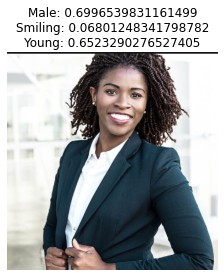

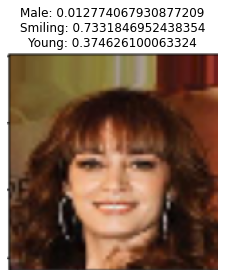

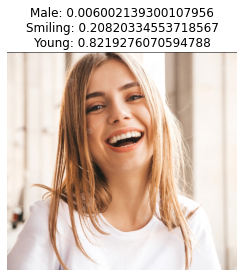

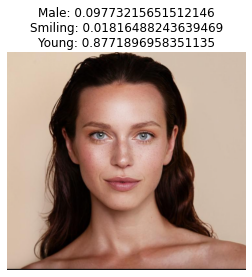

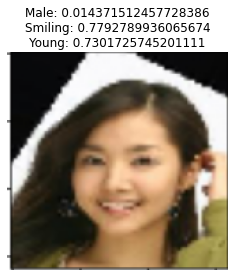

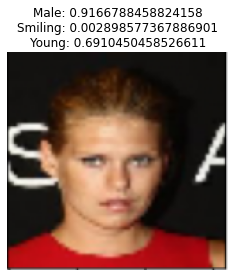

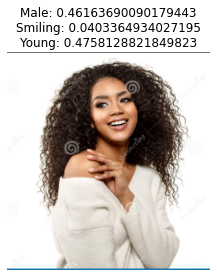

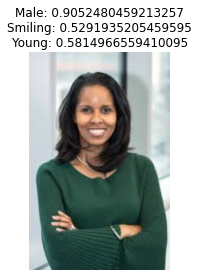

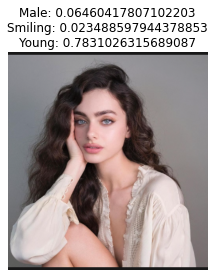

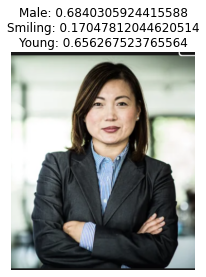

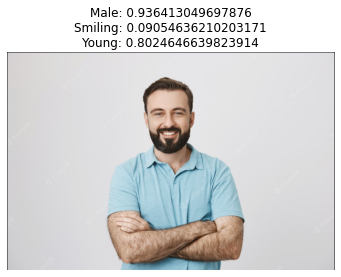

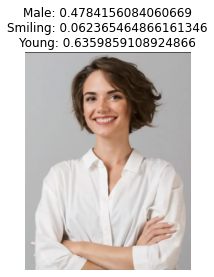

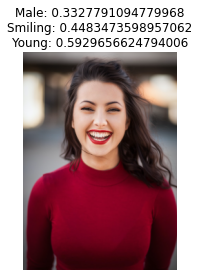

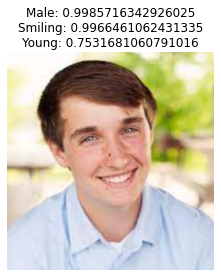

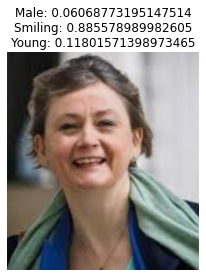

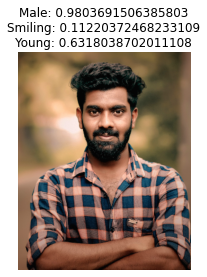

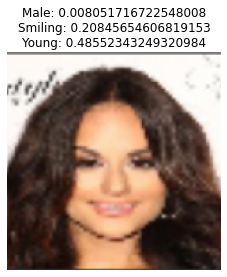

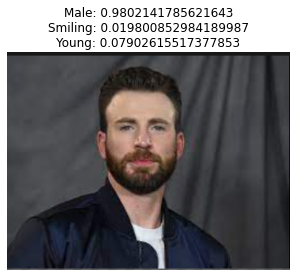

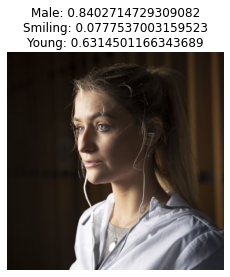

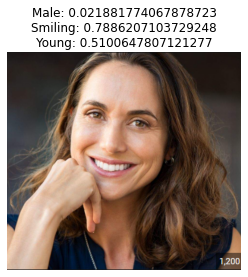

In [30]:
# Previewing

for i, img in enumerate(orig_imgs):
    title = "\n".join([f"{c}: {p_}" for (c, p_) in zip(COLS, preds[i])])
    plt.title(title)
    plt.imshow(img)
    plt.axis('off')
    plt.show()